<a href="https://colab.research.google.com/github/davione112/Collection_Preprocessing/blob/master/BikeSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**




In [65]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn import tree
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestRegressor
import math

# **Dataset**

In [2]:
url1 = 'https://raw.githubusercontent.com/davione112/work/master/train.csv'
url2 = 'https://raw.githubusercontent.com/davione112/work/master/test.csv'
train = pd.read_csv(url1)
test = pd.read_csv(url2)

- Brief summaries:


In [3]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [6]:
#@title Check for missing data
print(train.isnull().sum())
print(test.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


In [7]:
#@title Combine train and test into a dataset.
dataset = train.append(test)
dataset.reset_index(inplace=True)
dataset.drop('index',inplace=True,axis=1)
dataset = dataset.fillna(0)


In [8]:
dataset.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,0.0,0.0,0.0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,0.0,0.0,0.0
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,0.0,0.0,0.0


# **Understand variables and preprocessing** 


In [9]:
dataset.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual        float64
registered    float64
count         float64
dtype: object

## Distributions of continuous variables

Text(0.5, 1.0, 'Windspeed')

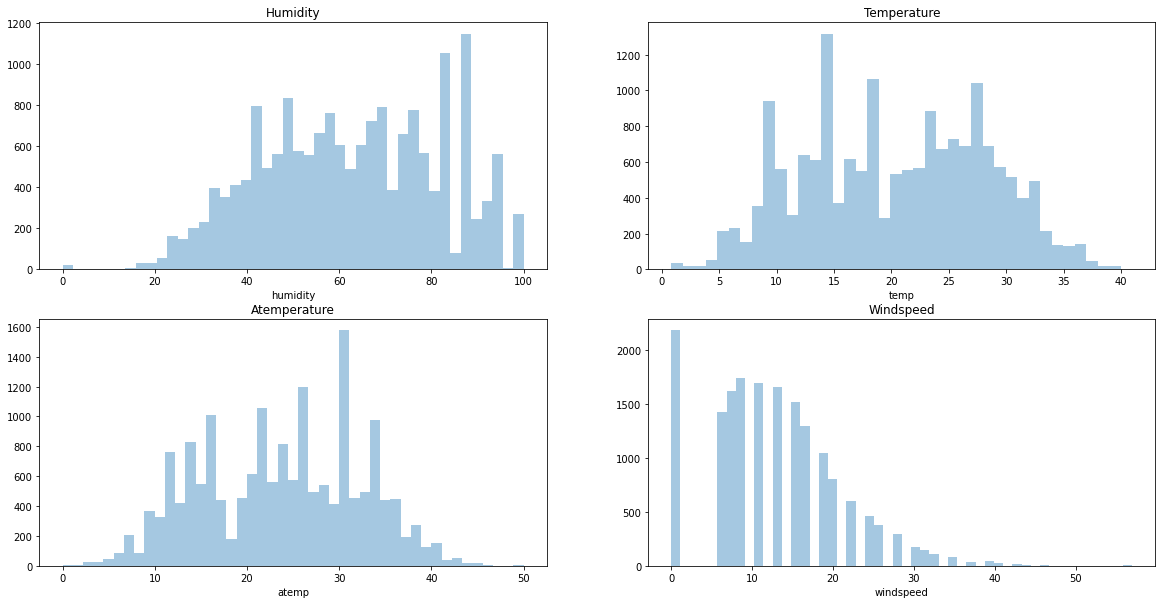

In [10]:

fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["humidity"],kde=False,ax=ax[0,0])
sb.distplot(dataset["temp"],kde=False,ax=ax[0,1])
sb.distplot(dataset["atemp"],kde=False,ax=ax[1,0])
sb.distplot(dataset["windspeed"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Humidity")
ax[0,1].set_title("Temperature")
ax[1,0].set_title("Atemperature")
ax[1,1].set_title("Windspeed")

- There are so many values = 0 in windspeed.
- Replace those values by median of column "windspeed".

12.736539622533591


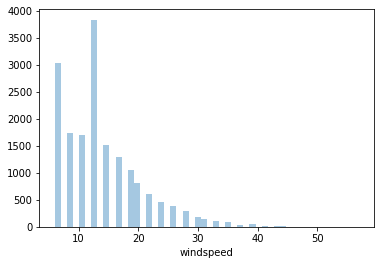

In [11]:
x = dataset['windspeed'].mean()
print(x)
dataset['windspeed'] = dataset['windspeed'].replace(0,x)
sb.distplot(dataset["windspeed"],kde=False)

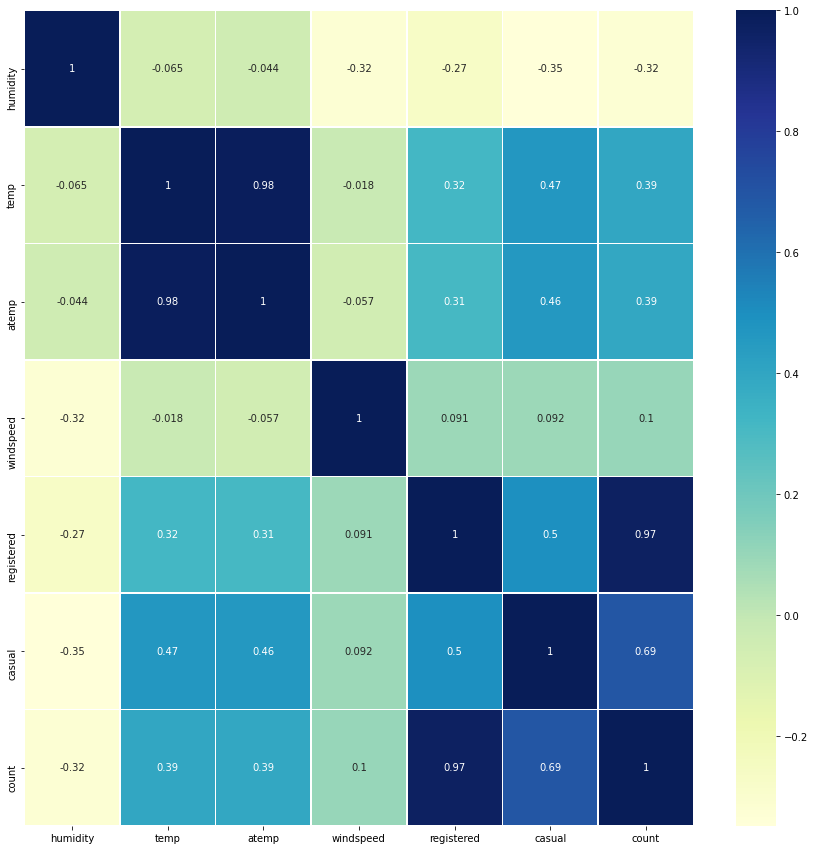

In [15]:
x = train[['humidity','temp','atemp','windspeed','registered','casual','count']].corr()
plt.figure(figsize=(15,15))
sb.heatmap(x, cmap='YlGnBu', annot=True, annot_kws={"size":10}, linewidths=0.5)

## Distributions of categorical variables


Text(0.5, 1.0, 'Workingday')

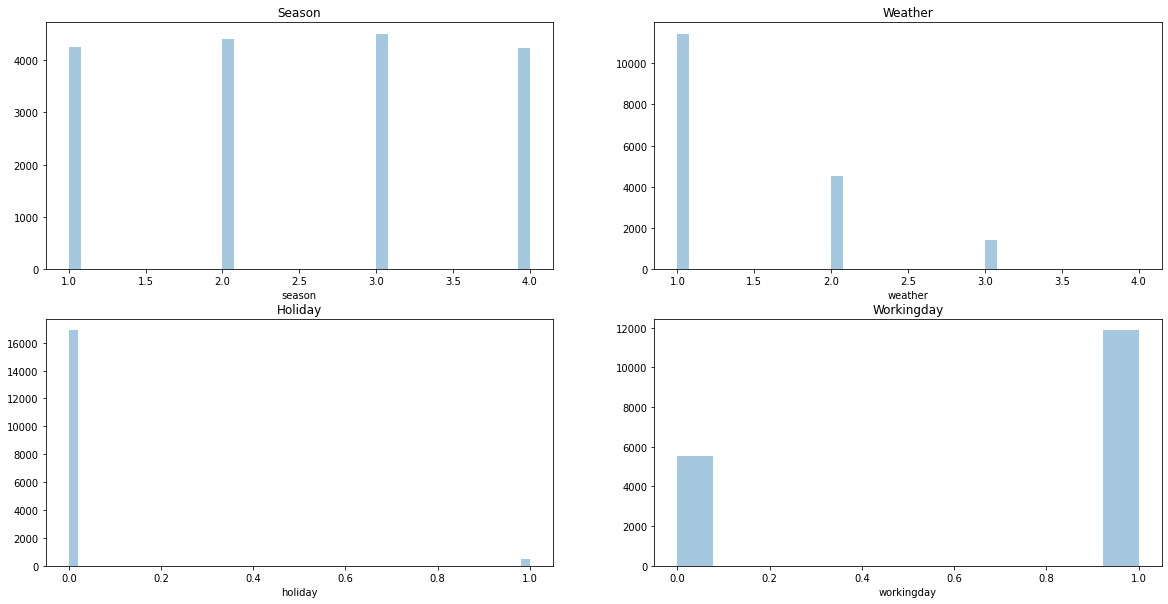

In [16]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["season"],kde=False,ax=ax[0,0])
sb.distplot(dataset["weather"],kde=False,ax=ax[0,1])
sb.distplot(dataset["holiday"],kde=False,ax=ax[1,0])
sb.distplot(dataset["workingday"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Season")
ax[0,1].set_title("Weather")
ax[1,0].set_title("Holiday")
ax[1,1].set_title("Workingday")

## Distribution of Count per each hours

In [18]:
# convert 'datetime' column to datetime datatype
dataset['datetime'] = pd.to_datetime(dataset['datetime'],
                                     format='%Y-%m-%d %H:%M:%S')

In [19]:
# add 'hour' and 'date' columns to dataset
hours = []
for i in range(len(dataset['datetime'])):
  hours.append(dataset['datetime'][i].hour)
dataset["hour"] = hours
dates = []
for i in range(len(dataset['datetime'])):
  dates.append(dataset['datetime'][i].day)
dataset["date"] = dates

In [20]:
# divide dataset into train and test
dataset[['season','holiday','weather','workingday']] = dataset[['season','holiday','weather','workingday']].astype('category')
dataset.head(5)
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date']) >=20]

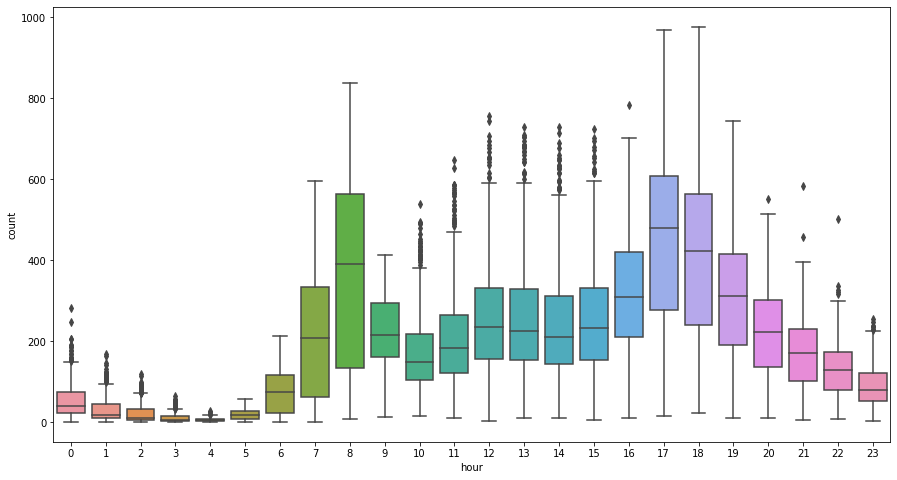

In [21]:
# boxplot bike rentals per hour in train set.
plt.figure(figsize=(15,8))
sb.boxplot(x='hour',y='count',data=train)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


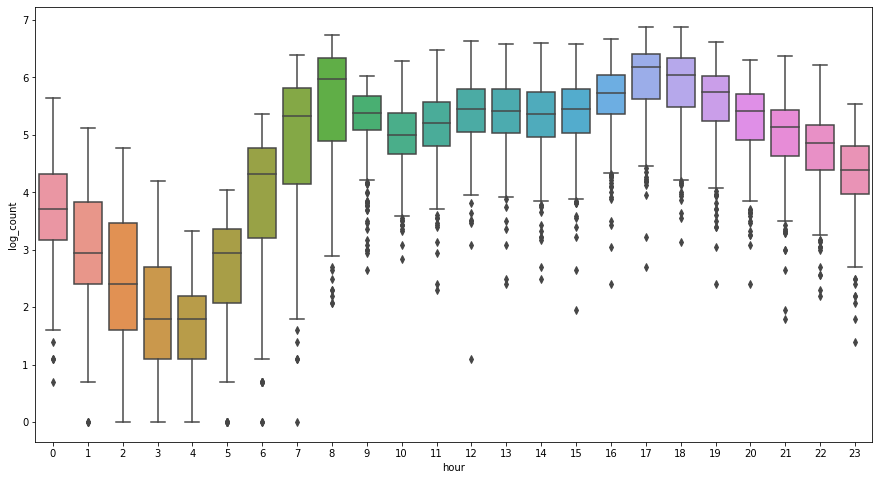

In [22]:
# Natural logarit with count and split into train and test.
dataset['log_count'] = np.log(dataset['count'])
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date']) >=20]

# Boxplot for 'log_count'
plt.figure(figsize=(15,8))
sb.boxplot(x='hour',y='log_count',data=train)

## Hour trending

Text(0.5, 1.0, 'Registered per hour')

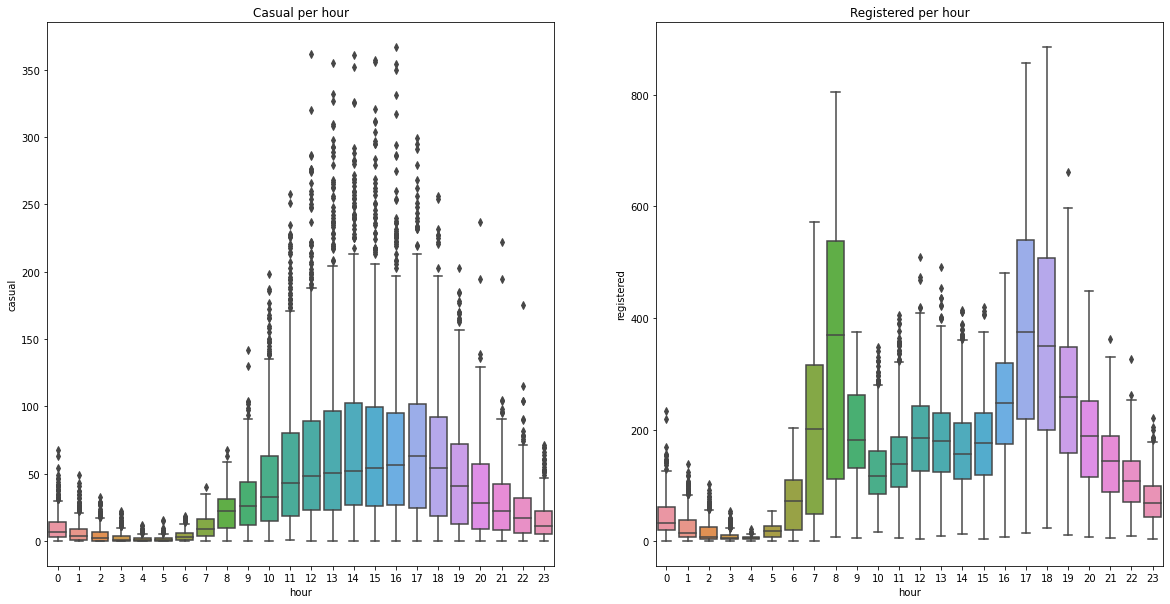

In [26]:
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='hour',y='casual',data=train,ax=axis1)
sb.boxplot(x='hour',y='registered',data=train,ax=axis2)

axis1.set_title('Casual per hour')
axis2.set_title('Registered per hour')

- From those 3 plots, we get some prediction:


1.   High count: 7-9 hour , 16-19 hour.
2.   Average count: 10-15 hour, 20-22 hour.
3.   Low count: 0-6 hour, 23 hour.

=> We can segregate into categories, with code lines below:


In [27]:
dataset['hour'] = dataset['hour'].astype('int64')
#dataset['hour_ctg'] = 0
dataset.loc[(dataset['hour']>=0) & (dataset['hour']<=6),'hour_ctg'] = 1
dataset.loc[(dataset['hour']>=23),'hour_ctg'] = 1
dataset.loc[(dataset['hour']>=7) & (dataset['hour']<=9),'hour_ctg'] = 3
dataset.loc[(dataset['hour']>=16) & (dataset['hour']<=19),'hour_ctg'] = 3
dataset.loc[(dataset['hour']>=10) & (dataset['hour']<=15),'hour_ctg'] = 2
dataset.loc[(dataset['hour']>=20) & (dataset['hour']<=22),'hour_ctg'] = 2

In [28]:
# divide dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date']) >=20]

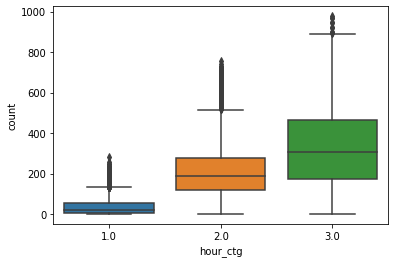

In [29]:
sb.boxplot(x='hour_ctg',y='count',data=train)

## Daily trend

In [30]:
# extracting days of week from datetime
days = []
for i in range(len(dataset['datetime'])):
  days.append(dataset['datetime'][i].weekday())
dataset['day'] = days

In [31]:
dataset.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
hour                   int64
date                   int64
log_count            float64
hour_ctg             float64
day                    int64
dtype: object

In [32]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

No handles with labels found to put in legend.


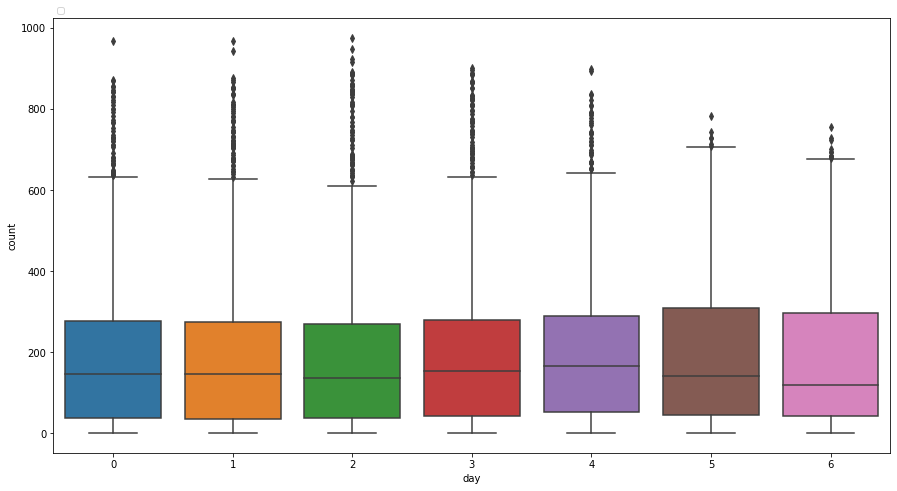

In [41]:
# Boxplot shows users’ demand over days.
plt.figure(figsize=(15,8))
sb.boxplot(x='day',y='count',data=train)

- In this plot: 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday.

Text(0.5, 1.0, 'Count per workingday')

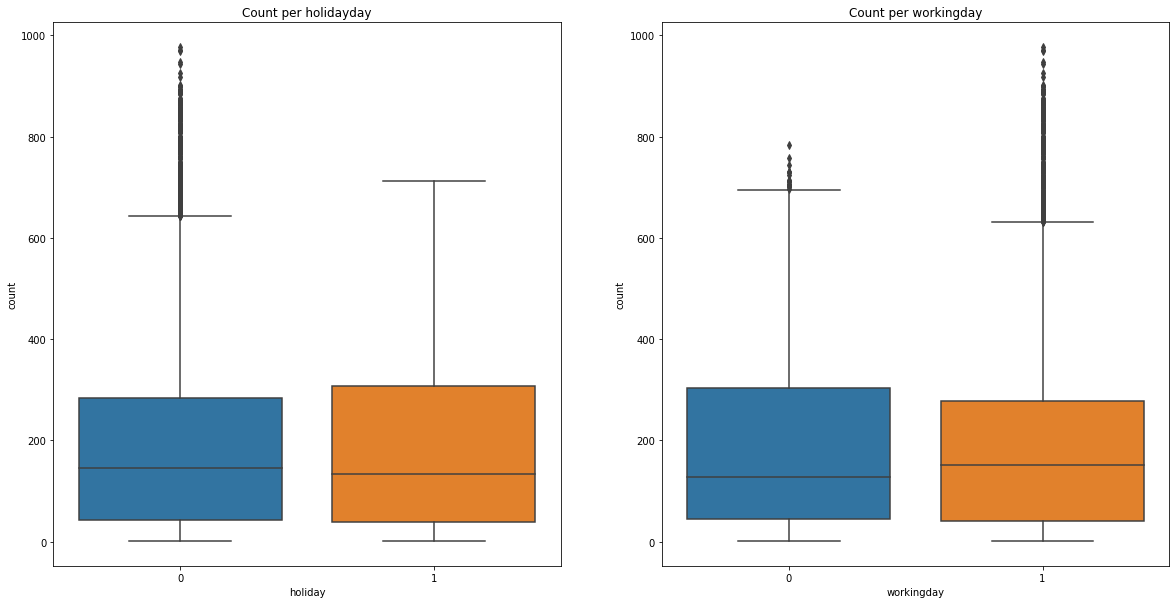

In [42]:
# Boxplot shows users’ demand over holidays.
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='holiday',y='count',data=train, ax=axis1)
sb.boxplot(x='workingday',y='count',data=train,ax=axis2)

axis1.set_title('Count per holidayday')
axis2.set_title('Count per workingday')

- 'holiday' boxplot and 'workingday' boxplot are similar.

## Weather trending

Text(0.5, 1.0, 'Registered per weather')

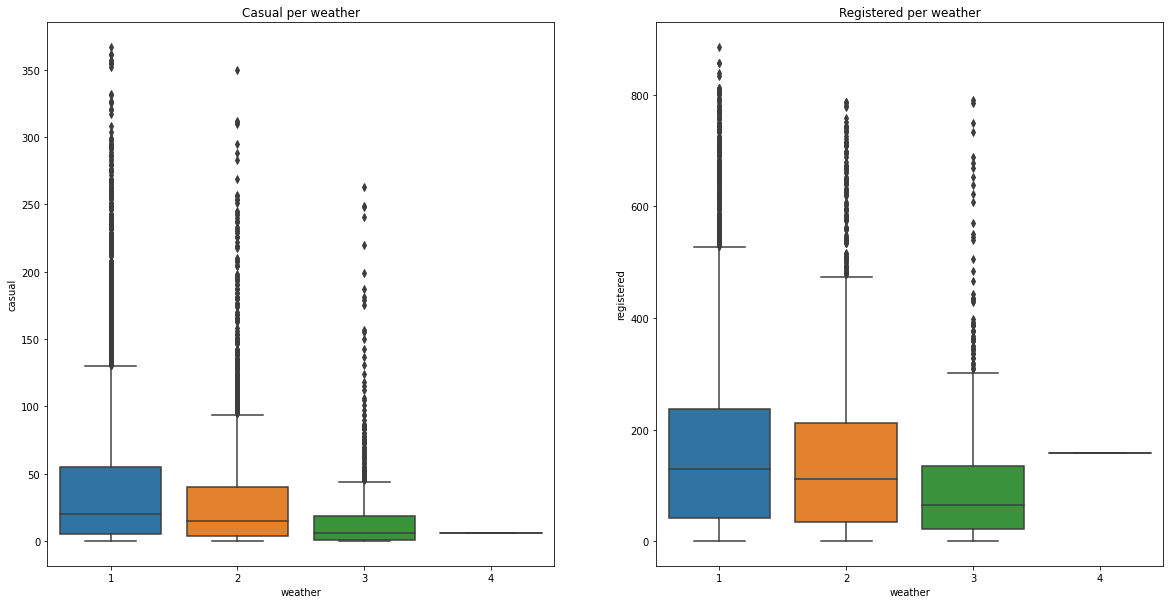

In [43]:
# Boxplot shows registered and casual users’ demand each weather.
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='weather',y='casual',data=train,ax=axis1)
sb.boxplot(x='weather',y='registered',data=train,ax=axis2)

axis1.set_title('Casual per weather')
axis2.set_title('Registered per weather')

## Comparision of bike rentals between 2011 and 2012

In [44]:
# Extract 'year' from datetime.
years = []
for i in range(len(dataset['datetime'])):
  years.append(dataset['datetime'][i].year)
dataset['year'] = years

In [45]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

Text(0.5, 1.0, 'bike rentals between 2011 and 2012')

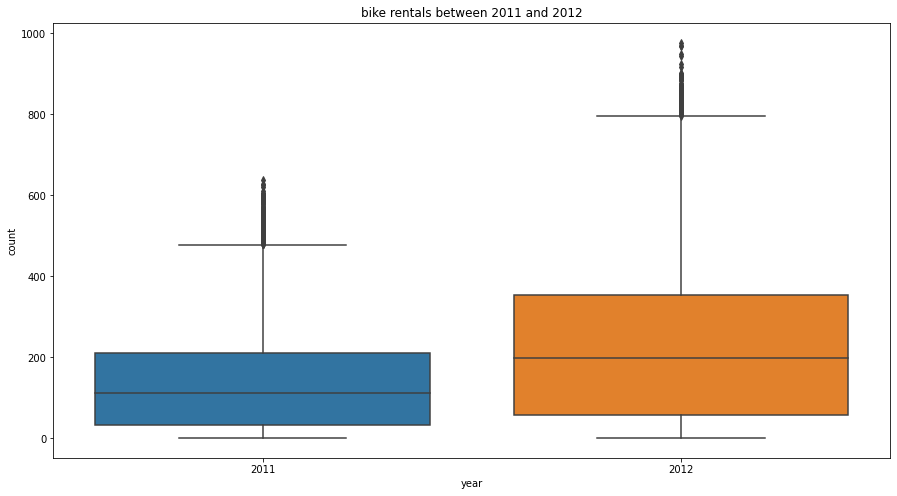

In [46]:
# Boxplot of bike rentals between '2011' and '2012'
plt.figure(figsize=(15,8))
sb.boxplot(x='year',y='count',data=train)
plt.title('bike rentals between 2011 and 2012')

##Season trending

In [47]:
# Combine 'year' and 'season'
dataset['year_season']= dataset['year'] + pd.to_numeric(dataset['season'])/10

In [48]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

Text(0.5, 1.0, 'bike rentals between each seasons in 2011 and 2012')

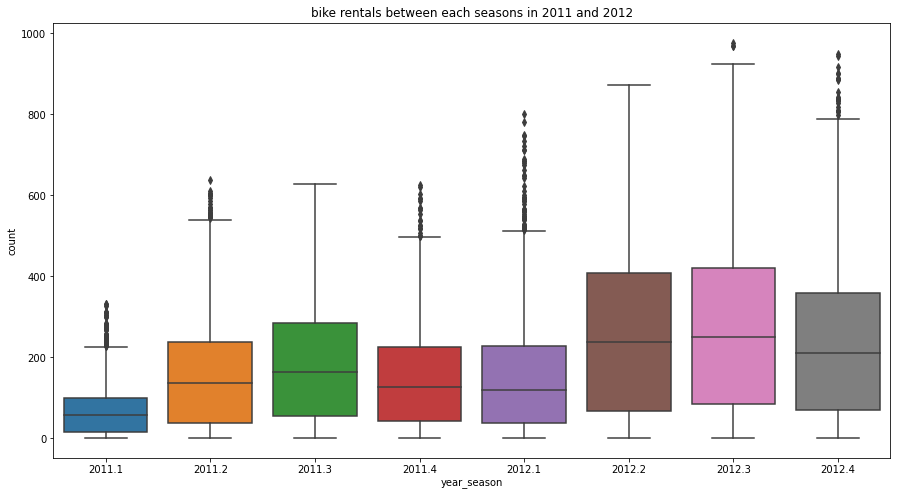

In [49]:
plt.figure(figsize=(15,8))
sb.boxplot(x='year_season',y='count',data=train)
plt.title('bike rentals between each seasons in 2011 and 2012')

- Amount of bike rentals in season 1,4 of 2011 and season 1 of 2012 is lower than the others season and there a lot outliers.
- We feature this 'year_season' using Median of each season.

In [50]:
# store median count each year seasons in x, join dataset with respect to 'year_season'.
x = dataset.groupby('year_season')[['count']].median()
x.columns = ['count_season']
dataset = dataset.join(x,on='year_season')

## Change datatype.

In [51]:
# Convert to 'category'.
list_var = ['hour_ctg','day','year','year_season','count_season']
for var in list_var:
  dataset[var] = dataset[var].astype('category')

In [52]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

# **Modeling**

In [54]:
train.dtypes

datetime        datetime64[ns]
season                category
holiday               category
workingday            category
weather               category
temp                   float64
atemp                  float64
humidity                 int64
windspeed              float64
casual                 float64
registered             float64
count                  float64
hour                     int64
date                     int64
log_count              float64
hour_ctg              category
day                   category
year                  category
year_season           category
count_season          category
dtype: object

In [53]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,log_count,hour_ctg,day,year,year_season,count_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,12.73654,3.0,13.0,16.0,0,1,2.772589,1.0,5,2011,2011.1,12.5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,12.73654,8.0,32.0,40.0,1,1,3.688879,1.0,5,2011,2011.1,12.5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,12.73654,5.0,27.0,32.0,2,1,3.465736,1.0,5,2011,2011.1,12.5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,12.73654,3.0,10.0,13.0,3,1,2.564949,1.0,5,2011,2011.1,12.5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,12.73654,0.0,1.0,1.0,4,1,0.000000,1.0,5,2011,2011.1,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.00270,7.0,329.0,336.0,19,19,5.817111,3.0,2,2012,2012.4,53.0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.00130,10.0,231.0,241.0,20,19,5.484797,2.0,2,2012,2012.4,53.0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.00130,4.0,164.0,168.0,21,19,5.123964,2.0,2,2012,2012.4,53.0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.00320,12.0,117.0,129.0,22,19,4.859812,2.0,2,2012,2012.4,53.0


In [55]:
test.reset_index(drop=True)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,log_count,hour_ctg,day,year,year_season,count_season
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.00270,0.0,0.0,0.0,0,20,-inf,1.0,3,2011,2011.1,12.5
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,12.73654,0.0,0.0,0.0,1,20,-inf,1.0,3,2011,2011.1,12.5
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,12.73654,0.0,0.0,0.0,2,20,-inf,1.0,3,2011,2011.1,12.5
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.00140,0.0,0.0,0.0,3,20,-inf,1.0,3,2011,2011.1,12.5
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.00140,0.0,0.0,0.0,4,20,-inf,1.0,3,2011,2011.1,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.00140,0.0,0.0,0.0,19,31,-inf,3.0,0,2012,2012.1,23.0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.00140,0.0,0.0,0.0,20,31,-inf,2.0,0,2012,2012.1,23.0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.00140,0.0,0.0,0.0,21,31,-inf,2.0,0,2012,2012.1,23.0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.99810,0.0,0.0,0.0,22,31,-inf,2.0,0,2012,2012.1,23.0


## Using Random forest regressor.

In [58]:
features = ['season','holiday','workingday','weather','temp','atemp',
            'humidity','windspeed','hour_ctg','day','count_season','year']
reg = RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=-1)
reg.fit(train[features],train['log_count'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [61]:
log_count_pred = reg.predict(train[features])
count_pred = np.exp(log_count_pred)
print(count_pred)

[ 12.34861302  13.18897201  13.18897201 ... 175.86994555 157.54583622
  46.62629709]


In [66]:
def RMSLE(predict, target):
    total = 0 
    for k in range(len(predict)):
        LPred= np.log1p(predict[k]+1)
        LTarg = np.log1p(target[k] + 1)
        if not (math.isnan(LPred)) and  not (math.isnan(LTarg)): 
            total = total + ((LPred-LTarg) **2)
        
    total = total / len(predict)        
    return np.sqrt(total)
print ('My RMSLE: ' + str(RMSLE(count_pred,train['count'])) )

My RMSLE: 0.30290469235770884
